In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime

## Random 充電/放電結果

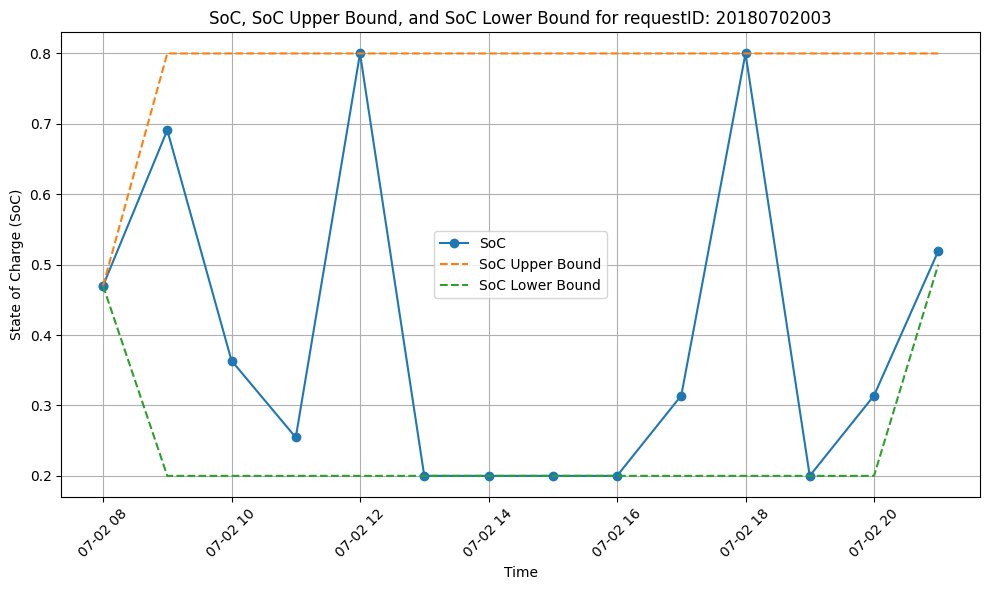

In [16]:
# Read the CSV file
file_path = './Result/VDN/1/soc_history.csv'
data = pd.read_csv(file_path)

# Convert 'current_time' to datetime
data['current_time'] = pd.to_datetime(data['current_time'])

# Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
def plot_soc_for_requestID(requestID):
    filtered_data = data[data['requestID'] == requestID]
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(filtered_data['current_time'], filtered_data['soc'], label='SoC', marker='o')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_upper_bound'], label='SoC Upper Bound', linestyle='--')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_lower_bound'], label='SoC Lower Bound', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('State of Charge (SoC)')
    plt.title(f'SoC, SoC Upper Bound, and SoC Lower Bound for requestID: {requestID}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

# Example usage 
plot_soc_for_requestID(20180702003)  # Replace with the desired requestID


## MARL 充電/放電結果

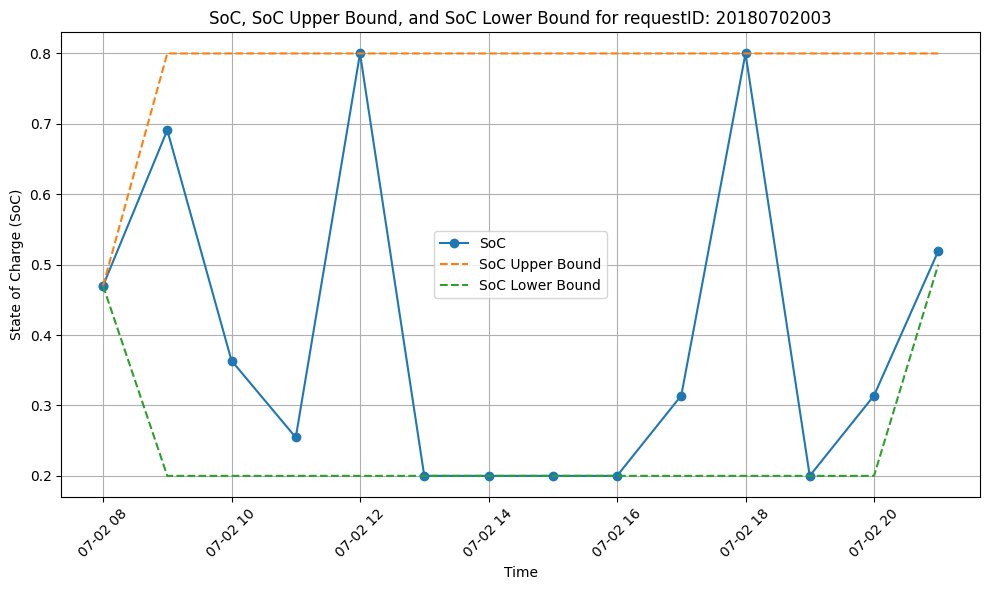

In [18]:
# Read the CSV file
file_path = './Result/VDN/1/soc_history.csv'
data = pd.read_csv(file_path)

# Convert 'current_time' to datetime
data['current_time'] = pd.to_datetime(data['current_time'])

# Function to plot SoC, SoC_upper_bound, and SoC_lower_bound for a given requestID
def plot_soc_for_requestID(requestID):
    filtered_data = data[data['requestID'] == requestID]
    
    plt.figure(figsize=(10, 6))
    
    plt.plot(filtered_data['current_time'], filtered_data['soc'], label='SoC', marker='o')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_upper_bound'], label='SoC Upper Bound', linestyle='--')
    plt.plot(filtered_data['current_time'], filtered_data['SoC_lower_bound'], label='SoC Lower Bound', linestyle='--')
    
    plt.xlabel('Time')
    plt.ylabel('State of Charge (SoC)')
    plt.title(f'SoC, SoC Upper Bound, and SoC Lower Bound for requestID: {requestID}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    plt.show()

# Example usage
plot_soc_for_requestID(20180702003)  # Replace with the desired requestID


## 原始負載與 EV 充放電的負載變化圖

In [2]:
def plot_load_history(file_path, start_date, end_date):
    # Read load history from CSV
    load_history_df = pd.read_csv(file_path, parse_dates=['current_time'])
    
    # Filter data by date range
    mask = (load_history_df['current_time'] >= start_date) & (load_history_df['current_time'] <= end_date)
    filtered_df = load_history_df.loc[mask]
    
    # Plot original load and total load as bar charts
    plt.figure(figsize=(14, 7))
    bar_width = 0.4
    bar_positions = range(len(filtered_df))
    
    plt.bar(bar_positions, filtered_df['original_load'], width=bar_width, label='Original Load', color='blue')
    plt.bar([p + bar_width for p in bar_positions], filtered_df['total_load'], width=bar_width, label='Load after Charging/Discharging', color='red')
    
    plt.xlabel('Time')
    plt.ylabel('Load (kWh)')
    plt.title('Building Load: Original vs After Charging/Discharging')
    plt.xticks([p + bar_width/2 for p in bar_positions], filtered_df['current_time'].dt.strftime('%Y-%m-%d %H:%M:%S'), rotation=90)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

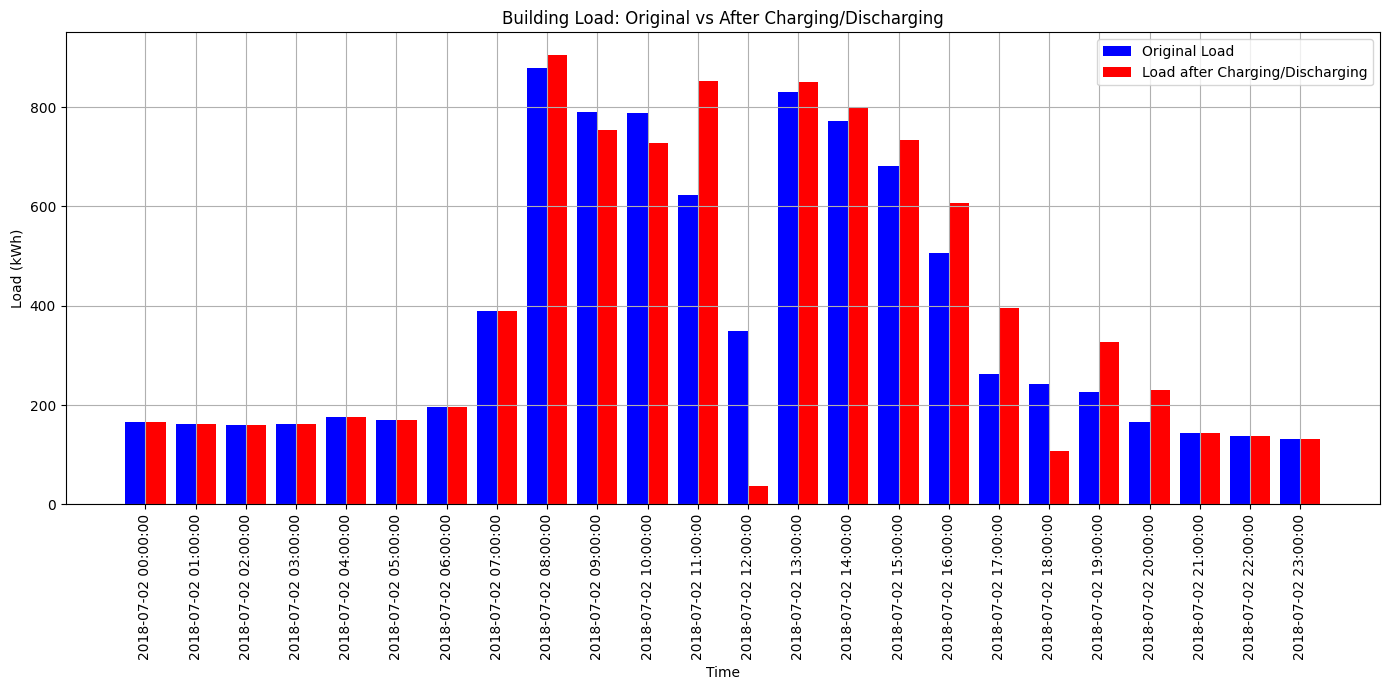

In [20]:
file_path = './Result/VDN/1/building_loading_history.csv'  # Modify this to the path of your load history file
start_date = '2018-07-02'
end_date = '2018-07-03'

# Convert string dates to datetime objects
start_date = datetime.strptime(start_date, '%Y-%m-%d')
end_date = datetime.strptime(end_date, '%Y-%m-%d')

plot_load_history(file_path, start_date, end_date)